In [4]:
"""
UHID Essex County - Road Network & Traffic Integration
Author: Samuel
Date: November 2025
Purpose: Integrate road network and AADT traffic data with LST grid

This notebook:
1. Loads road shapefile and traffic count data
2. Merges traffic volumes with road geometry
3. Calculates traffic density per grid cell
4. Estimates anthropogenic heat contribution
5. Aligns with LST grid for modeling
"""

'\nUHID Essex County - Road Network & Traffic Integration\nAuthor: Samuel\nDate: November 2025\nPurpose: Integrate road network and AADT traffic data with LST grid\n\nThis notebook:\n1. Loads road shapefile and traffic count data\n2. Merges traffic volumes with road geometry\n3. Calculates traffic density per grid cell\n4. Estimates anthropogenic heat contribution\n5. Aligns with LST grid for modeling\n'

In [14]:
# Quick traffic data exploration
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [15]:
# ============================================
# Load Traffic Data
# ============================================
traffic = pd.read_excel('/content/drive/MyDrive/SharedFilesUHIDTeam/06_RoadNetwork and Traffic/TrafficCount2024DataSetwithAADTs.xlsx')

essex_traffic = traffic[traffic['County'] == 'Essex'].copy()

print(f"✓ {len(essex_traffic)} traffic stations in Essex County")
print(f"  AADT range: {essex_traffic['AADT'].min():,.0f} - {essex_traffic['AADT'].max():,.0f}")


✓ 240 traffic stations in Essex County
  AADT range: 70 - 125,120


In [16]:
# ============================================
# Create GeoDataFrame from Lat/Lon
# ============================================
essex_traffic['geometry'] = essex_traffic.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)

traffic_gdf = gpd.GeoDataFrame(essex_traffic, crs='EPSG:4326')

print(f"\n✓ Created GeoDataFrame with {len(traffic_gdf)} points")



✓ Created GeoDataFrame with 240 points


In [17]:
# ============================================
# Load LST Grid for Reference
# ============================================
lst_file = '/content/drive/MyDrive/SharedFilesUHIDTeam/01_Satellite_LST/processed/Essex_LST_Celsius.tif'

with rasterio.open(lst_file) as src:
    lst_profile = src.profile
    lst_transform = src.transform
    lst_shape = (src.height, src.width)
    lst_crs = src.crs

    # Reproject traffic points to match LST
    traffic_gdf = traffic_gdf.to_crs(lst_crs)

print(f"✓ Reprojected traffic stations to {lst_crs}")


✓ Reprojected traffic stations to EPSG:32618


In [18]:
# ============================================
# Create Traffic Density Grid
# ============================================
from scipy.ndimage import gaussian_filter

In [19]:
# Create empty grid
traffic_grid = np.zeros(lst_shape, dtype=np.float32)

# For each traffic station, add influence to nearby cells
print("\nRasterizing traffic influence...")

for idx, station in traffic_gdf.iterrows():
    # Get pixel coordinates
    col, row = ~lst_transform * (station.geometry.x, station.geometry.y)
    col, row = int(col), int(row)

    # Check bounds
    if 0 <= row < lst_shape[0] and 0 <= col < lst_shape[1]:
        # Add AADT value to grid
        traffic_grid[row, col] += station['AADT']

# Apply Gaussian blur to create influence zones (traffic affects nearby areas)
traffic_density = gaussian_filter(traffic_grid, sigma=3)  # 3-pixel radius

# Normalize
traffic_density = traffic_density / traffic_density.max() * 100  # Scale 0-100

print(f"✓ Traffic density grid created")
print(f"  Max value: {traffic_density.max():.1f}")
print(f"  Non-zero cells: {np.sum(traffic_density > 0):,}")



Rasterizing traffic influence...
✓ Traffic density grid created
  Max value: 100.0
  Non-zero cells: 20,931



✓ Visualization saved


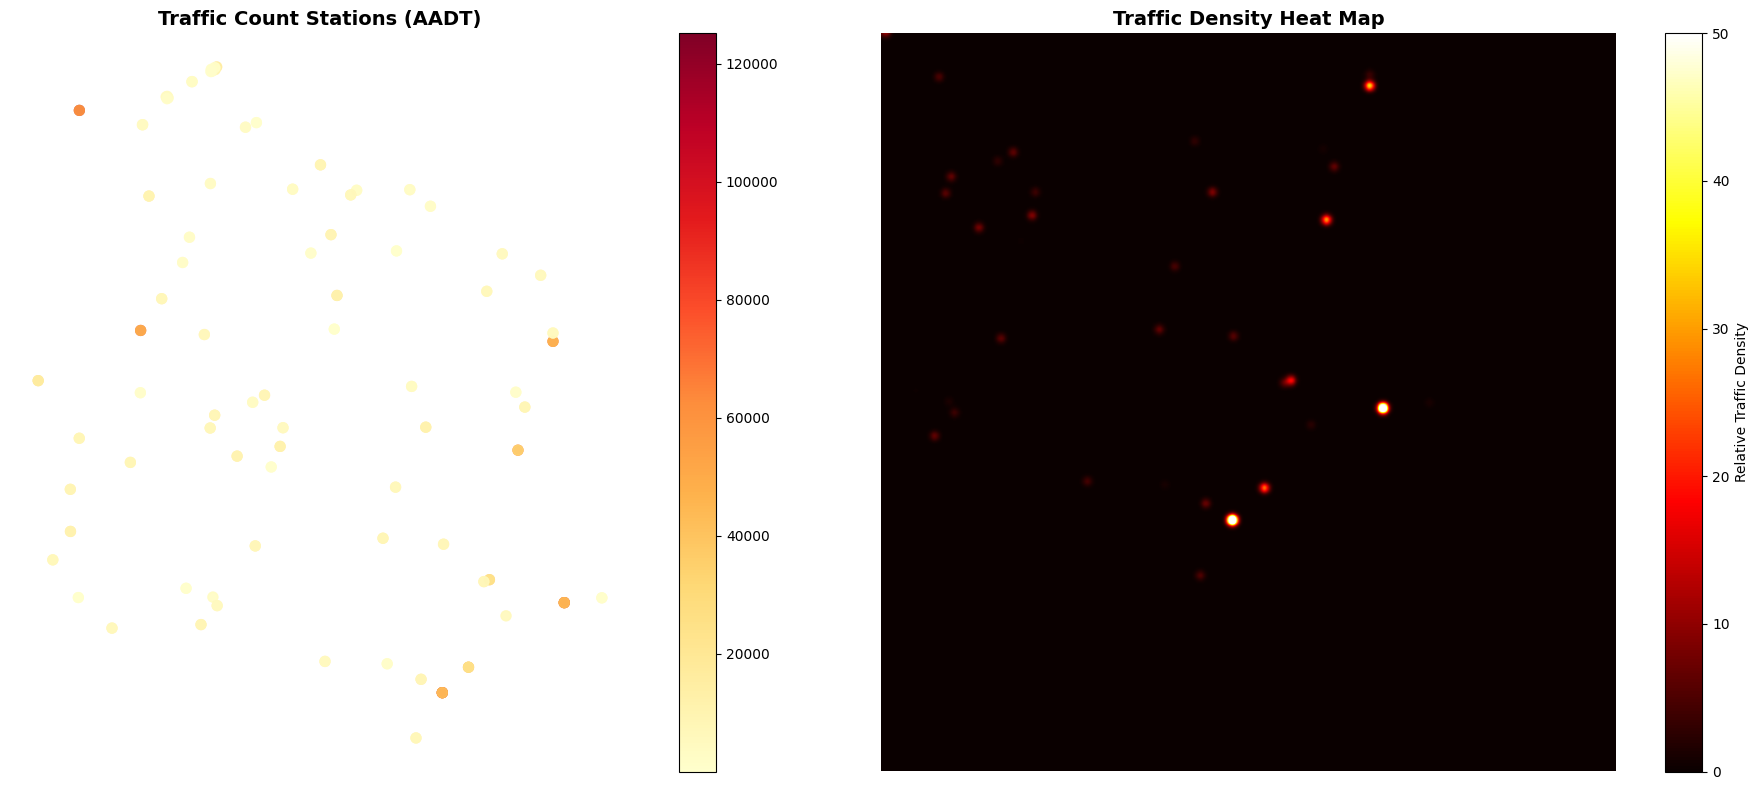

In [20]:
# ============================================
# Visualize
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Traffic stations
traffic_gdf.plot(ax=axes[0], column='AADT', cmap='YlOrRd',
                 markersize=50, legend=True, alpha=0.7)
axes[0].set_title('Traffic Count Stations (AADT)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Plot 2: Traffic density grid
im = axes[1].imshow(traffic_density, cmap='hot', vmin=0, vmax=50)
axes[1].set_title('Traffic Density Heat Map', fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], label='Relative Traffic Density')

plt.tight_layout()
plt.savefig('Traffic_Analysis_Essex.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved")
plt.show()

In [21]:
# ============================================
# Export Traffic Grid
# ============================================
output_folder = '/content/drive/MyDrive/SharedFilesUHIDTeam/06_RoadNetwork and Traffic/processed'
import os
os.makedirs(output_folder, exist_ok=True)

# Save traffic density raster
export_profile = lst_profile.copy()
export_profile.update(dtype=rasterio.float32, count=1, nodata=-9999)

with rasterio.open(f'{output_folder}/Essex_TrafficDensity_Grid.tif', 'w', **export_profile) as dst:
    dst.write(traffic_density.astype(rasterio.float32), 1)

print(f"✓ Exported: Essex_TrafficDensity_Grid.tif")

# Save stations as GeoJSON
traffic_gdf.to_file(f'{output_folder}/Essex_Traffic_Stations.geojson', driver='GeoJSON')
print(f"✓ Exported: Essex_Traffic_Stations.geojson")

print("\n" + "="*60)
print("✅ TRAFFIC INTEGRATION COMPLETE")
print("="*60)
print(f"\n240 traffic stations processed")
print(f"Ready for correlation with LST!")

✓ Exported: Essex_TrafficDensity_Grid.tif
✓ Exported: Essex_Traffic_Stations.geojson

✅ TRAFFIC INTEGRATION COMPLETE

240 traffic stations processed
Ready for correlation with LST!
